In [1]:
import os
os.chdir("../../../../")

import itertools
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy

#!pip install pmdarima
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima import model_selection
from pmdarima import auto_arima
from scripts.python.ts_utils import * 
from scripts.python.tsmodel import * 

import warnings
warnings.filterwarnings('ignore')

In [2]:
folder = os.getcwd() + "/data/tourism/tonga/intermediate/"
filepath = [folder + file for file in os.listdir(folder) if ".csv" in file]

## Load and Merge

In [3]:
tonga = pd.read_csv(filepath[0]).drop("Unnamed: 0", axis=1)
tonga.groupby(by="Year").count()

,Air,Ship,Yacht,Total,date
Year,,,,,
2010,12,12,12,12,12
2011,12,11,12,12,12
2012,12,12,12,12,12
2013,12,12,12,12,12
2014,12,12,12,12,12
2015,12,12,12,12,12
2016,12,12,12,12,12
2017,12,12,12,12,12
2018,12,12,12,12,12


In [4]:
from scripts.python.PdfParse import check_quality
idxes = check_quality(tonga, ["date", "Year"], "Total")
for idx in idxes:
    combined_strs = str(tonga.iloc[idx, 1]) + str(tonga.iloc[idx, 2])
    combined_num = float(combined_strs)
    if combined_num == float(tonga["Total"][idx]):
        tonga.iloc[idx, 1], tonga.iloc[idx, 2] = combined_num, 0

In [5]:
tonga = (tonga.drop_duplicates().reset_index().drop("index", axis=1))
tonga["date"] = pd.to_datetime(tonga["date"] )
tonga.groupby(by="Year").count()

,Air,Ship,Yacht,Total,date
Year,,,,,
2010,12,12,12,12,12
2011,12,11,12,12,12
2012,12,12,12,12,12
2013,12,12,12,12,12
2014,12,12,12,12,12
2015,12,12,12,12,12
2016,12,12,12,12,12
2017,12,12,12,12,12
2018,12,12,12,12,12


### Covid

In [6]:
oceania_ci = (pd.read_csv(os.getcwd() + "/data/tourism/oceania_covid_stringency.csv")
                .drop("Unnamed: 0", axis=1))
oceania_ci["date"] = pd.to_datetime(oceania_ci["date"])
oceania_ci.head(5)

,year,month,stringency_index,date
0,2020,1,6.485000,2020-01-01
1,2020,2,18.961379,2020-02-01
2,2020,3,41.960753,2020-03-01
3,2020,4,82.458000,2020-04-01
4,2020,5,64.930000,2020-05-01


In [7]:
tonga = (tonga.merge(oceania_ci, how="left", on="date")
              .drop(["year", "month"], axis=1)
              .rename({"stringency_index": "covid"}, axis=1)
              .fillna(0))
tonga.head(5)

,Year,Air,Ship,Yacht,Total,date,covid
0,2010,3158,646.0,4.0,3808,2010-01-01,0.0
1,2010,2379,0.0,5.0,2384,2010-02-01,0.0
2,2010,3134,853.0,5.0,3992,2010-03-01,0.0
3,2010,2818,2802.0,30.0,5650,2010-04-01,0.0
4,2010,3670,5303.0,177.0,9150,2010-05-01,0.0


In [8]:
gt = pd.read_csv(os.getcwd() + "/data/tourism/trends/trends_tonga.csv").drop("Unnamed: 0", axis=1)
gt["date"] = pd.to_datetime(gt["date"])
gt.columns = [col.replace(" ", "_") for col in gt.columns]
gt.head(5)

,date,tonga_flights-AU,tonga_hotel-AU,tonga_travel-AU,tonga_flights-NZ,tonga_hotel-NZ,tonga_travel-NZ,tonga_flights-US,tonga_hotel-US,tonga_travel-US,...,tonga_travel-JP,tonga_flights-HK,tonga_hotel-HK,tonga_travel-HK,tonga_flights-NC,tonga_hotel-NC,tonga_travel-NC,tonga_flights,tonga_hotel,tonga_travel
0,2004-01-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
1,2004-02-01,0,0,0,0,0,0,0,59,0,...,0,0,0,0,0,0,0,2.256111,3.711238,0.000000
2,2004-03-01,79,85,0,0,0,80,100,66,0,...,0,0,0,0,0,0,0,0.000000,0.000000,2.093351
3,2004-04-01,100,0,0,58,90,0,0,0,0,...,0,0,0,0,0,0,0,3.598893,7.354399,0.000000
4,2004-05-01,0,56,81,54,0,0,0,0,0,...,0,0,0,0,0,0,0,2.376195,2.340261,0.000000


In [9]:
tonga = tonga.merge(gt[["date", "tonga_travel"]], how="left", on="date")

In [10]:
get_adf_df(tonga.diff().dropna(), ["Total"])

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
Total,-3.967867,0.001588,9.0,133.0,-3.4805,-2.883528,-2.578496


## SARIMAX

In [20]:
from scripts.python.ts_eval import *
naive_pred = naive_method(tonga["Total"])
mean_pred = mean_method(tonga["Total"])
snaive_pred = seasonal_naive_method(tonga["Total"])

benchmark = pd.DataFrame()
for idx, pred in enumerate([naive_pred, mean_pred, snaive_pred]):
    metrics = calculate_evaluation(tonga["Total"], pred)
    metrics_df = pd.DataFrame(metrics, index=[idx])
    benchmark = pd.concat([benchmark, metrics_df], axis=0)

benchmark.index = ["naive", "mean", "seasonal naive"]
benchmark

,MSE,RMSE,MAE,MAPE
naive,6.720486e+06,2592.389998,1908.237762,inf
mean,8.166202e+06,2857.656689,2195.029803,inf
seasonal naive,1.177298e+07,3431.178177,2387.833333,inf


training size : 133, testing size : 11
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=483.721, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=486.977, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=444.353, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=484.980, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=444.795, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=446.266, Time=0.18 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=444.746, Time=0.18 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=444.447, Time=0.07 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=482.791, Time=0.05 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=442.785, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=442.762, Time=0.03 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=442.857, Time=0.07 sec
 A

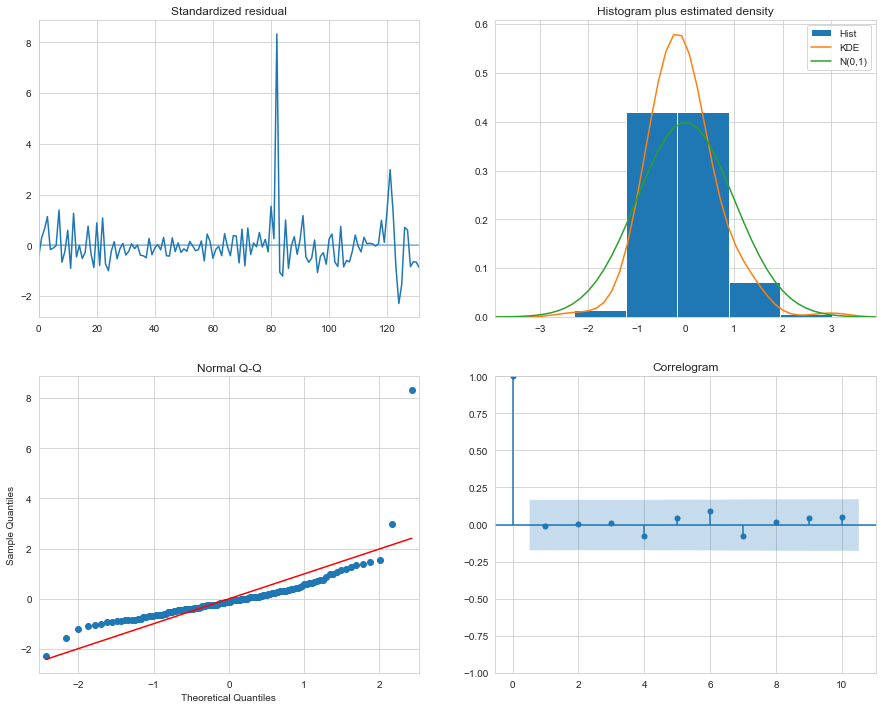

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (3, 1, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (1, 0, 0, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

In [11]:
tg = SARIMAXPipeline(data=tonga, y_var="Total", transform_method="scaledlogit",
                     exog_var=["covid", "tonga_travel"], training_ratio=0.925)
tg.transform()
tg.stepwise_search()

In [12]:
# Set parameter range
p, d, q = range(0, 3), range(0, 2), range(0, 3)
P, D, Q, s = range(0, 3), range(0, 2), range(0, 3), [12]

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq, seasonal_pdq))

tg_msres = tg.manual_search(params=all_param)
tg_msres.sort(key=lambda x: x[1])

Tried out SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:417.24
Tried out SARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC:416.09
Tried out SARIMAX(0, 0, 0)x(0, 0, 2, 12) - AIC:418.02
Tried out SARIMAX(0, 0, 0)x(0, 1, 0, 12) - AIC:435.72
Tried out SARIMAX(0, 0, 0)x(0, 1, 1, 12) - AIC:403.67
Tried out SARIMAX(0, 0, 0)x(0, 1, 2, 12) - AIC:404.94
Tried out SARIMAX(0, 0, 0)x(1, 0, 0, 12) - AIC:415.86
Tried out SARIMAX(0, 0, 0)x(1, 0, 1, 12) - AIC:417.21
Tried out SARIMAX(0, 0, 0)x(1, 0, 2, 12) - AIC:419.2
Tried out SARIMAX(0, 0, 0)x(1, 1, 0, 12) - AIC:420.06
Tried out SARIMAX(0, 0, 0)x(1, 1, 1, 12) - AIC:404.95
Tried out SARIMAX(0, 0, 0)x(1, 1, 2, 12) - AIC:402.81
Tried out SARIMAX(0, 0, 0)x(2, 0, 0, 12) - AIC:417.64
Tried out SARIMAX(0, 0, 0)x(2, 0, 1, 12) - AIC:419.2
Tried out SARIMAX(0, 0, 0)x(2, 0, 2, 12) - AIC:417.67
Tried out SARIMAX(0, 0, 0)x(2, 1, 0, 12) - AIC:410.13
Tried out SARIMAX(0, 0, 0)x(2, 1, 1, 12) - AIC:406.95
Tried out SARIMAX(0, 0, 0)x(2, 1, 2, 12) - AIC:404.77
Tried out SARIMAX(0, 0, 1)x(0,

Tried out SARIMAX(1, 0, 2)x(1, 0, 2, 12) - AIC:417.19
Tried out SARIMAX(1, 0, 2)x(1, 1, 0, 12) - AIC:420.04
Tried out SARIMAX(1, 0, 2)x(1, 1, 1, 12) - AIC:399.83
Tried out SARIMAX(1, 0, 2)x(1, 1, 2, 12) - AIC:396.81
Tried out SARIMAX(1, 0, 2)x(2, 0, 0, 12) - AIC:416.03
Tried out SARIMAX(1, 0, 2)x(2, 0, 1, 12) - AIC:417.22
Tried out SARIMAX(1, 0, 2)x(2, 0, 2, 12) - AIC:415.94
Tried out SARIMAX(1, 0, 2)x(2, 1, 0, 12) - AIC:409.04
Tried out SARIMAX(1, 0, 2)x(2, 1, 1, 12) - AIC:401.71
Tried out SARIMAX(1, 0, 2)x(2, 1, 2, 12) - AIC:398.79
Tried out SARIMAX(1, 1, 0)x(0, 0, 0, 12) - AIC:442.8
Tried out SARIMAX(1, 1, 0)x(0, 0, 1, 12) - AIC:442.46
Tried out SARIMAX(1, 1, 0)x(0, 0, 2, 12) - AIC:444.45
Tried out SARIMAX(1, 1, 0)x(0, 1, 0, 12) - AIC:465.04
Tried out SARIMAX(1, 1, 0)x(0, 1, 1, 12) - AIC:420.14
Tried out SARIMAX(1, 1, 0)x(0, 1, 2, 12) - AIC:422.12
Tried out SARIMAX(1, 1, 0)x(1, 0, 0, 12) - AIC:442.36
Tried out SARIMAX(1, 1, 0)x(1, 0, 1, 12) - AIC:442.76
Tried out SARIMAX(1, 1, 0)x(1

Tried out SARIMAX(2, 1, 1)x(2, 1, 2, 12) - AIC:399.88
Tried out SARIMAX(2, 1, 2)x(0, 0, 0, 12) - AIC:420.96
Tried out SARIMAX(2, 1, 2)x(0, 0, 1, 12) - AIC:420.53
Tried out SARIMAX(2, 1, 2)x(0, 0, 2, 12) - AIC:422.46
Tried out SARIMAX(2, 1, 2)x(0, 1, 0, 12) - AIC:440.88
Tried out SARIMAX(2, 1, 2)x(0, 1, 1, 12) - AIC:400.21
Tried out SARIMAX(2, 1, 2)x(0, 1, 2, 12) - AIC:402.06
Tried out SARIMAX(2, 1, 2)x(1, 0, 0, 12) - AIC:420.27
Tried out SARIMAX(2, 1, 2)x(1, 0, 1, 12) - AIC:420.78
Tried out SARIMAX(2, 1, 2)x(1, 0, 2, 12) - AIC:422.72
Tried out SARIMAX(2, 1, 2)x(1, 1, 0, 12) - AIC:424.71
Tried out SARIMAX(2, 1, 2)x(1, 1, 1, 12) - AIC:402.09
Tried out SARIMAX(2, 1, 2)x(1, 1, 2, 12) - AIC:399.37
Tried out SARIMAX(2, 1, 2)x(2, 0, 0, 12) - AIC:422.12
Tried out SARIMAX(2, 1, 2)x(2, 0, 1, 12) - AIC:422.82
Tried out SARIMAX(2, 1, 2)x(2, 0, 2, 12) - AIC:420.68
Tried out SARIMAX(2, 1, 2)x(2, 1, 0, 12) - AIC:414.34
Tried out SARIMAX(2, 1, 2)x(2, 1, 1, 12) - AIC:403.36
Tried out SARIMAX(2, 1, 2)x(

In [13]:
tg_models = []
tg_sw = tg.stepwise_model
tg_models.append(pm.ARIMA(
    tg_sw["order"], tg_sw["seasonal_order"],  exog=tg.exog[:tg.training_size]))
for res in tg_msres[:5]:
    order, seasonal_order = res[-1]
    model = pm.ARIMA(order, seasonal_order, exog=tg.exog[:tg.training_size])
    tg_models.append(model)

tg_comp = tg.compare_models(
    y=tg.transformed_y[:tg.training_size],
    exog=tg.exog[:tg.training_size],
    models=tg_models)

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

In [15]:
tg_comp

{'model': [ARIMA(order=(3, 1, 1), seasonal_order=(1, 0, 0, 12)),
  ARIMA(order=(2, 0, 2), seasonal_order=(1, 1, 2, 12)),
  ARIMA(order=(2, 0, 2), seasonal_order=(1, 1, 1, 12)),
  ARIMA(order=(0, 0, 2), seasonal_order=(1, 1, 2, 12)),
  ARIMA(order=(2, 0, 2), seasonal_order=(0, 1, 2, 12)),
  ARIMA(order=(2, 0, 2), seasonal_order=(2, 1, 2, 12))],
 'cv_scores': [array([137.78045607,  88.35047907, 105.93923129,  94.19948027,
         185.22178215, 178.67599052, 137.89627087,  92.37235137,
         104.36323921, 156.43891927, 150.68450766, 126.07302805,
         188.39250879, 145.8030008 , 146.32543051, 163.73911199,
         105.05588339, 132.67218764, 190.17406785]),
  array([129.57963682, 111.75253503,  95.96125819,  73.76250855,
          48.07406274,  74.9485934 ,  82.48083698,  83.71838468,
          87.85275217, 103.89088116, 137.05197579, 151.53058086,
         151.48338696, 144.27232426, 146.92612131, 162.69124144,
         155.9523769 , 156.51100768, 181.53493128]),
  array([129.57

In [16]:
best_scaled = tg_msres[3][0]
scaled_mod = tg.get_prediction_df(best_scaled, steps=tg.test_size, exog=tg.exog[-tg.test_size:])
scaled_mod.columns.name = None

In [17]:
lower = tonga["Total"].min() - 1
upper = tonga["Total"].max() + 1

for col_idx, col in enumerate(scaled_mod.columns):
    for row_idx, _ in enumerate(scaled_mod[col]):
        scaled_mod.iloc[row_idx, col_idx] = tg.inverse_scaledlogit(
            scaled_mod.iloc[row_idx, col_idx], upper, lower)
        
scaled_mod = pd.concat([tonga[["date", "Total"]], scaled_mod], axis=1)
scaled_mod.head(5)

,date,Total,train_pred,mean_se,mean_ci_lower,mean_ci_upper,test_pred
0,2010-01-01,3808,6903.615654,NaN,-1.0,NaN,NaN
1,2010-02-01,2384,7238.663896,NaN,-1.0,NaN,NaN
2,2010-03-01,3992,6930.498807,NaN,-1.0,NaN,NaN
3,2010-04-01,5650,7138.765764,NaN,-1.0,NaN,NaN
4,2010-05-01,9150,7571.539595,NaN,-1.0,NaN,NaN


In [23]:
scaled_pred = scaled_mod["train_pred"].fillna(0) + scaled_mod["test_pred"].fillna(0)
pd.DataFrame(calculate_evaluation(tonga["Total"], scaled_pred), index=["scaled logit"])

,MSE,RMSE,MAE,MAPE
scaled logit,4.284694e+06,2069.950238,1454.360421,inf


Text(0.5, 1.0, "Tonga's Visitor Arrivals")

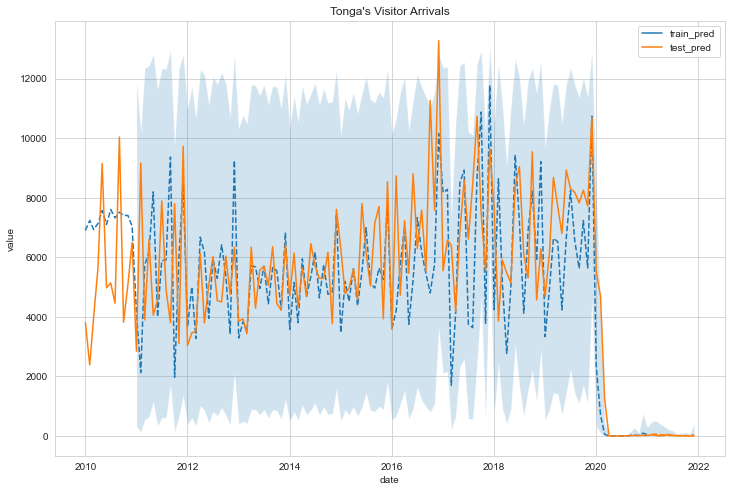

In [24]:
scaled_viz_df = scaled_mod[["date", "train_pred", "test_pred"]].melt(id_vars=["date"])

fig, ax = plt.subplots(figsize=(12,8))
ax.fill_between(x="date", y1="mean_ci_lower", y2="mean_ci_upper", data=scaled_mod, alpha=0.2)
sns.lineplot(data=scaled_viz_df, x="date", y="value", hue="variable", linestyle="--")
sns.lineplot(data=scaled_mod, x="date", y="Total")
plt.title("Tonga's Visitor Arrivals")

### No-scaled

training size : 133, testing size : 11
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2462.143, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2466.125, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2395.937, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2464.138, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2394.790, Time=0.02 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2396.096, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2392.972, Time=0.15 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=2392.556, Time=0.48 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2395.836, Time=0.22 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=2390.743, Time=0.52 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2396.511, Time=0.35 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=2451.052, Time

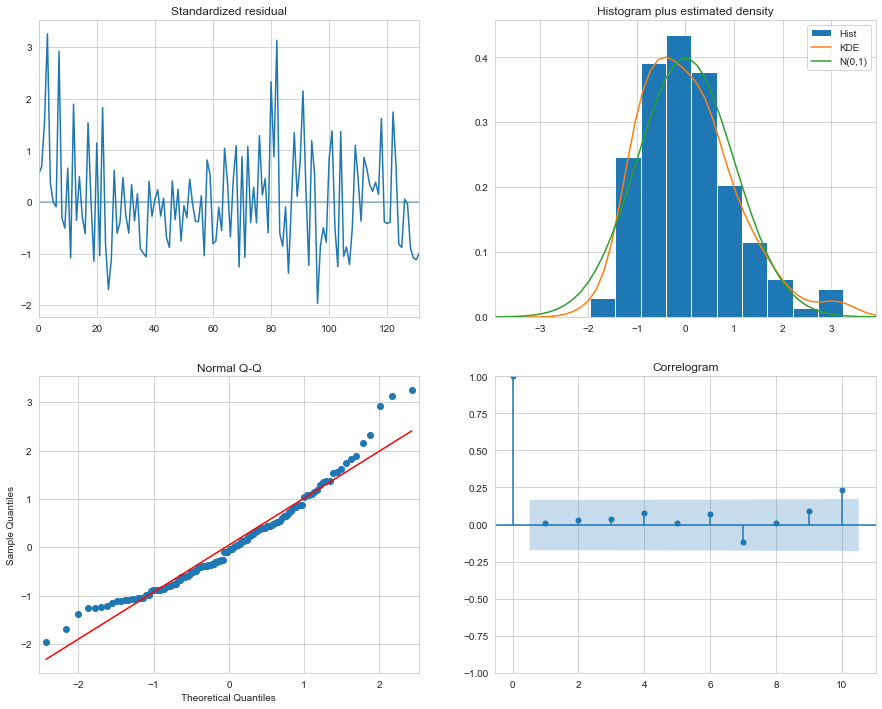

Tried out SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:2536.41
Tried out SARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC:2504.09
Tried out SARIMAX(0, 0, 0)x(0, 0, 2, 12) - AIC:2504.06
Tried out SARIMAX(0, 0, 0)x(0, 1, 0, 12) - AIC:2217.52
Tried out SARIMAX(0, 0, 0)x(0, 1, 1, 12) - AIC:2191.52
Tried out SARIMAX(0, 0, 0)x(0, 1, 2, 12) - AIC:2193.38
Tried out SARIMAX(0, 0, 0)x(1, 0, 0, 12) - AIC:2495.55
Tried out SARIMAX(0, 0, 0)x(1, 0, 1, 12) - AIC:2491.15
Tried out SARIMAX(0, 0, 0)x(1, 0, 2, 12) - AIC:2494.8
Tried out SARIMAX(0, 0, 0)x(1, 1, 0, 12) - AIC:2199.62
Tried out SARIMAX(0, 0, 0)x(1, 1, 1, 12) - AIC:2193.45
Tried out SARIMAX(0, 0, 0)x(1, 1, 2, 12) - AIC:2190.56
Tried out SARIMAX(0, 0, 0)x(2, 0, 0, 12) - AIC:2468.92
Tried out SARIMAX(0, 0, 0)x(2, 0, 1, 12) - AIC:2494.84
Tried out SARIMAX(0, 0, 0)x(2, 0, 2, 12) - AIC:2493.28
Tried out SARIMAX(0, 0, 0)x(2, 1, 0, 12) - AIC:2189.31
Tried out SARIMAX(0, 0, 0)x(2, 1, 1, 12) - AIC:2191.36
Tried out SARIMAX(0, 0, 0)x(2, 1, 2, 12) - AIC:2190.3
Tried out SA

Tried out SARIMAX(1, 0, 2)x(1, 0, 1, 12) - AIC:2468.38
Tried out SARIMAX(1, 0, 2)x(1, 0, 2, 12) - AIC:2472.95
Tried out SARIMAX(1, 0, 2)x(1, 1, 0, 12) - AIC:2195.92
Tried out SARIMAX(1, 0, 2)x(1, 1, 1, 12) - AIC:2177.99
Tried out SARIMAX(1, 0, 2)x(1, 1, 2, 12) - AIC:2178.45
Tried out SARIMAX(1, 0, 2)x(2, 0, 0, 12) - AIC:2476.64
Tried out SARIMAX(1, 0, 2)x(2, 0, 1, 12) - AIC:2472.98
Tried out SARIMAX(1, 0, 2)x(2, 0, 2, 12) - AIC:2473.43
Tried out SARIMAX(1, 0, 2)x(2, 1, 0, 12) - AIC:2177.85
Tried out SARIMAX(1, 0, 2)x(2, 1, 1, 12) - AIC:2167.75
Tried out SARIMAX(1, 0, 2)x(2, 1, 2, 12) - AIC:2178.93
Tried out SARIMAX(1, 1, 0)x(0, 0, 0, 12) - AIC:2392.78
Tried out SARIMAX(1, 1, 0)x(0, 0, 1, 12) - AIC:2394.09
Tried out SARIMAX(1, 1, 0)x(0, 0, 2, 12) - AIC:2394.51
Tried out SARIMAX(1, 1, 0)x(0, 1, 0, 12) - AIC:2242.67
Tried out SARIMAX(1, 1, 0)x(0, 1, 1, 12) - AIC:2170.38
Tried out SARIMAX(1, 1, 0)x(0, 1, 2, 12) - AIC:2171.06
Tried out SARIMAX(1, 1, 0)x(1, 0, 0, 12) - AIC:2393.93
Tried out 

Tried out SARIMAX(2, 1, 1)x(2, 0, 1, 12) - AIC:2371.46
Tried out SARIMAX(2, 1, 1)x(2, 0, 2, 12) - AIC:2373.77
Tried out SARIMAX(2, 1, 1)x(2, 1, 0, 12) - AIC:2166.18
Tried out SARIMAX(2, 1, 1)x(2, 1, 1, 12) - AIC:2174.09
Tried out SARIMAX(2, 1, 1)x(2, 1, 2, 12) - AIC:2174.84
Tried out SARIMAX(2, 1, 2)x(0, 0, 0, 12) - AIC:2374.75
Tried out SARIMAX(2, 1, 2)x(0, 0, 1, 12) - AIC:2374.52
Tried out SARIMAX(2, 1, 2)x(0, 0, 2, 12) - AIC:2376.19
Tried out SARIMAX(2, 1, 2)x(0, 1, 0, 12) - AIC:2213.53
Tried out SARIMAX(2, 1, 2)x(0, 1, 1, 12) - AIC:2165.45
Tried out SARIMAX(2, 1, 2)x(0, 1, 2, 12) - AIC:2170.82
Tried out SARIMAX(2, 1, 2)x(1, 0, 0, 12) - AIC:2373.9
Tried out SARIMAX(2, 1, 2)x(1, 0, 1, 12) - AIC:2372.13
Tried out SARIMAX(2, 1, 2)x(1, 0, 2, 12) - AIC:2372.24
Tried out SARIMAX(2, 1, 2)x(1, 1, 0, 12) - AIC:2186.93
Tried out SARIMAX(2, 1, 2)x(1, 1, 1, 12) - AIC:2171.1
Tried out SARIMAX(2, 1, 2)x(1, 1, 2, 12) - AIC:2171.48
Tried out SARIMAX(2, 1, 2)x(2, 0, 0, 12) - AIC:2373.53
Tried out SA

In [35]:
to = SARIMAXPipeline(data=tonga, y_var="Total", transform_method=None,
                     exog_var=["covid", "tonga_travel"], training_ratio=0.925)
to.transform()
to.stepwise_search()

# Set parameter range
p, d, q = range(0, 3), range(0, 2), range(0, 3)
P, D, Q, s = range(0, 3), range(0, 2), range(0, 3), [12]

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq, seasonal_pdq))
to_msres = to.manual_search(all_param)

In [36]:
to_msres.sort(key=lambda x: x[1])

In [37]:
to_models = []
to_sw = to.stepwise_model
to_models.append(pm.ARIMA(
    to_sw["order"], to_sw["seasonal_order"],  exog=to.exog[:to.training_size]))
for res in to_msres[:5]:
    order, seasonal_order = res[-1]
    model = pm.ARIMA(order, seasonal_order, exog=to.exog[:to.training_size])
    to_models.append(model)

to_comp = to.compare_models(
    y=to.transformed_y[:to.training_size],
    exog=to.exog[:to.training_size],
    models=to_models)

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

In [66]:
to_comp

{'model': [ARIMA(order=(3, 1, 1), seasonal_order=(0, 0, 0, 12)),
  ARIMA(order=(0, 1, 1), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(1, 1, 1), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(0, 1, 2), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(0, 1, 1), seasonal_order=(0, 1, 2, 12)),
  ARIMA(order=(0, 1, 1), seasonal_order=(1, 1, 1, 12))],
 'cv_scores': [array([ 52.96399436,  51.74929486,  41.03691595,  39.04906299,
          47.42687422,  27.76992714,  39.70371672,  16.26571286,
          20.21663188,  37.21630216,  25.31040231,  31.68726126,
          56.0727873 ,  42.70858359,  58.00974279,  28.64926313,
          12.53434225,  84.00633547, 176.99975625]),
  array([ 62.14458448,  47.37106117,  98.7672845 ,  22.53520854,
          64.48359207,  34.04303963,  54.20231524,  46.32263484,
          57.65310144,  51.76066676,  45.34384808,  50.09813484,
          90.59140459,  59.64437086,  75.66449958,  54.51304773,
          18.11612212,  87.60862866, 179.50699842]),
  array([ 62.14

In [96]:
best_original = to_msres[1][0]
original_mod = to.get_prediction_df(best_original, steps=to.test_size, exog=to.exog[-to.test_size:])
original_mod.columns.name = None
original_mod = pd.concat([tonga[["date", "Total"]], original_mod], axis=1)
original_mod.head(5)

,date,Total,train_pred,mean_se,mean_ci_lower,mean_ci_upper,test_pred
0,2010-01-01,3808,24.565101,3453.288485,-6743.755958,6792.886160,NaN
1,2010-02-01,2384,2044.052740,2870.707558,-3582.430685,7670.536164,NaN
2,2010-03-01,3992,2434.358430,2747.612384,-2950.862885,7819.579746,NaN
3,2010-04-01,5650,2945.151310,2717.189335,-2380.441926,8270.744546,NaN
4,2010-05-01,9150,4005.043912,2708.967628,-1304.435074,9314.522898,NaN


In [98]:
org_pred = original_mod["train_pred"].fillna(0) + original_mod["test_pred"].fillna(0)
org_eval = pd.DataFrame(calculate_evaluation(tonga["Total"], org_pred), index=["original"])
org_eval

,MSE,RMSE,MAE,MAPE
original,3.714746e+06,1927.367743,1457.947999,inf


In [88]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
best_ori_mod = SARIMAX(to.transformed_y.iloc[:to.training_size],
                       exog=to.exog[:to.training_size],
                       order=(3,1,1),
                       seasonal_order=(0,0,0,12)).fit(disp=False)
best_ori_mod.summary()
bo_predict = best_ori_mod.get_prediction().summary_frame()
bo_forecast = best_ori_mod.get_forecast(steps= to.test_size, exog=to.exog[-to.test_size:]).summary_frame()

In [89]:
bo_predict = pd.concat([bo_predict, bo_forecast], axis=0)


Total,mean,mean_se,mean_ci_lower,mean_ci_upper
0,-271.312241,2909.154760,-5973.150797,5430.526315
1,1136.324066,2169.137896,-3115.108088,5387.756220
2,2583.373686,2006.133573,-1348.575866,6515.323237
3,2474.864954,1959.228418,-1365.152183,6314.882091
4,2636.688548,1932.637832,-1151.211998,6424.589095
...,...,...,...,...
139,633.121741,1965.288746,-3218.773420,4485.016902
140,140.628713,1973.161876,-3726.697500,4007.954926
141,166.170477,1980.922514,-3716.366306,4048.707261
142,18.657495,1988.499934,-3878.730759,3916.045750


In [93]:
pd.DataFrame(calculate_evaluation(tonga["Total"], bo_predict["mean"]), index=["original"])

,MSE,RMSE,MAE,MAPE
original,3.330977e+06,1825.096439,1421.944704,inf


## VARMAX

In [52]:
tg_merged = pd.read_csv(filepath[-1]).drop("Unnamed: 0", axis=1)
tg_merged["date"] = pd.to_datetime(tg_merged["date"])
tg_merged.head(5)

,Year,Month,Number_of_flights_intl,Number_of_flights_total,Seats_arrivals_intl,Seats_arrivals_total,Air,Ship,Yacht,Total,date
0,2019,1,68.0,102.0,14706.0,17698.0,4372,313.0,3.0,4688,2019-01-01
1,2019,2,45.0,80.0,9740.0,11440.0,2709,3448.0,0.0,6157,2019-02-01
2,2019,3,55.0,107.0,10236.0,12662.0,3109,5570.0,7.0,8686,2019-03-01
3,2019,4,53.0,78.0,10615.0,10919.0,4183,3508.0,13.0,7704,2019-04-01
4,2019,5,64.0,87.0,11858.0,12226.0,5166,1506.0,128.0,6800,2019-05-01


## Ratio

In [53]:
gt = pd.read_csv(os.getcwd() + "/data/tourism/trends/trends_tonga.csv").drop("Unnamed: 0", axis=1)
gt["date"] = pd.to_datetime(gt["date"])
gt.head(5)

,date,tonga flights-AU,tonga hotel-AU,tonga travel-AU,tonga flights-NZ,tonga hotel-NZ,tonga travel-NZ,tonga flights-US,tonga hotel-US,tonga travel-US,...,tonga travel-JP,tonga flights-HK,tonga hotel-HK,tonga travel-HK,tonga flights-NC,tonga hotel-NC,tonga travel-NC,tonga flights,tonga hotel,tonga travel
0,2004-01-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
1,2004-02-01,0,0,0,0,0,0,0,59,0,...,0,0,0,0,0,0,0,2.256111,3.711238,0.000000
2,2004-03-01,79,85,0,0,0,80,100,66,0,...,0,0,0,0,0,0,0,0.000000,0.000000,2.093351
3,2004-04-01,100,0,0,58,90,0,0,0,0,...,0,0,0,0,0,0,0,3.598893,7.354399,0.000000
4,2004-05-01,0,56,81,54,0,0,0,0,0,...,0,0,0,0,0,0,0,2.376195,2.340261,0.000000


In [54]:
tg_merged["ratio"] = tg_merged["Air"]/tg_merged["Seats_arrivals_intl"]
temp = (tg_merged[["date", "ratio"]].merge(oceania_ci, how="left", on="date")
        .drop(["year", "month"], axis=1)
        .fillna(0))
temp["covid"] = temp.date >= "2020-03-12"
temp["quarter"] = temp["date"].dt.quarter
temp = temp.merge(gt[["date", "tonga flights", "tonga travel"]], how="left", on="date")
temp.columns = [col.replace(" ", "_") for col in temp.columns]
temp.head(5)

,date,ratio,stringency_index,covid,quarter,tonga_flights,tonga_travel
0,2019-01-01,0.297294,0.0,False,1,1.075798,0.203206
1,2019-02-01,0.278131,0.0,False,1,0.940670,0.230846
2,2019-03-01,0.303732,0.0,False,1,0.852194,0.268547
3,2019-04-01,0.394065,0.0,False,2,0.793732,0.132975
4,2019-05-01,0.435655,0.0,False,2,0.976347,0.247394


In [55]:
get_adf_df(temp, ["ratio"])

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
ratio,-0.807989,0.816764,0.0,37.0,-3.620918,-2.943539,-2.6104


In [56]:
import statsmodels.formula.api as smf
res = smf.wls(
    formula="ratio ~ covid * stringency_index + C(quarter) + tonga_travel", data=temp).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  ratio   R-squared:                       0.957
Model:                            WLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     95.35
Date:                Fri, 21 Apr 2023   Prob (F-statistic):           9.93e-19
Time:                        15:57:42   Log-Likelihood:                 65.703
No. Observations:                  38   AIC:                            -115.4
Df Residuals:                      30   BIC:                            -102.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.3402      0.035      9.829      0.000       0.270       0.411
covid[T.True]                     -0.3766      0.057     -6.568      0.000      -0.494      -0.259
C(quarter)[T.2]                    0.0878      0.026      3.390      0.002       0.035       0.141
C(quarter)[T.3]                    0.1138      0.025      4.534      0.000       0.063       0.165
C(quarter)[T.4]                    0.0803      0.024      3.282      0.003       0.030       0.130
stringency_index                  -0.0045      0.001     -3.661      0.001      -0.007      -0.002
covid[T.True]:stringency_index     0.0032      0.002      1.856      0.073      -0.000       0.007
tonga_travel                       0.0789      0.097      0.815      0.422      -0.119       0.277
==============================================================================
Omnibus:                        4.403   Durbin-Watson:                   1.009
Prob(Omnibus):                  0.111   Jarque-Bera (JB):                3.644
Skew:                           0.758   Prob(JB):                        0.162
Kurtosis:                       3.054   Cond. No.                         719.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

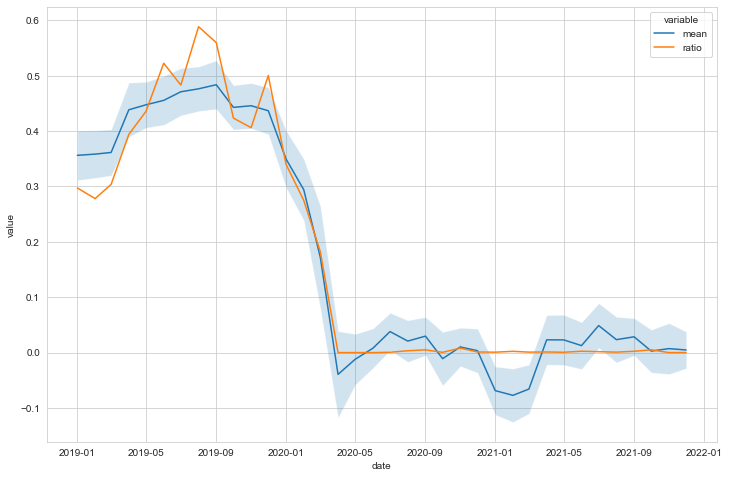

In [57]:
ratio_pred = res.get_prediction().summary_frame()
ratio_stats = pd.concat([temp, ratio_pred], axis=1)

ratio_viz_df = ratio_stats[["mean", "ratio", "date"]].melt(id_vars="date")

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=ratio_viz_df, x="date", y="value", hue="variable")
ax.fill_between(data=ratio_stats, x="date", y1="mean_ci_lower",
                y2="mean_ci_upper", alpha=0.2)
plt.show()

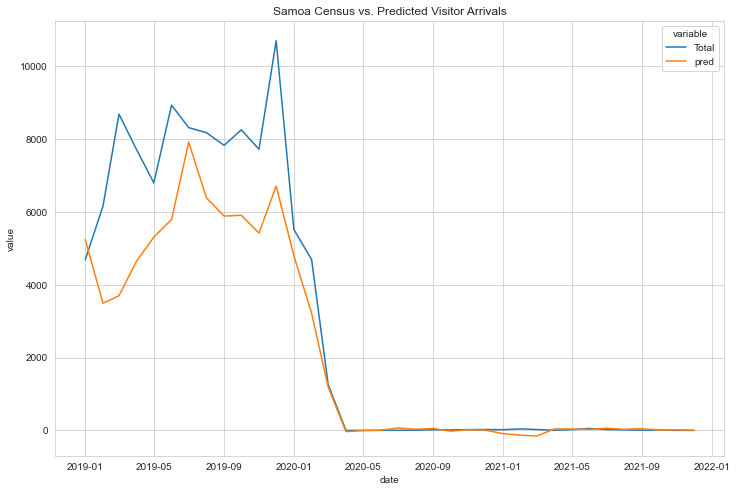

In [58]:
tg_merged["pred"] = ratio_stats["mean"] * tg_merged["Seats_arrivals_intl"]

pred_viz_df = tg_merged[["date", "Total", "pred"]].melt(id_vars="date")
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=pred_viz_df, x="date", y="value", hue="variable")
plt.title("Samoa Census vs. Predicted Visitor Arrivals")
plt.show()

In [62]:
var_mean = mean_method(tg_merged["Total"])
var_naive = naive_method(tg_merged["Total"])

var_metrics = pd.DataFrame()
for idx, pred in enumerate([var_mean, var_naive]):
    df = pd.DataFrame(calculate_evaluation(tg_merged["Total"], pred), index=[idx])
    var_metrics = pd.concat([var_metrics, df], axis=0)
    
var_metrics.index = ["mean", "naive"]
var_metrics

,MSE,RMSE,MAE,MAPE
mean,1.368747e+07,3699.657587,3432.540166,inf
naive,1.776518e+06,1332.860792,647.945946,inf


In [64]:
pd.DataFrame(calculate_evaluation(tg_merged["Total"], tg_merged["pred"]), index=["ratio"])

,MSE,RMSE,MAE,MAPE
ratio,2.377501e+06,1541.914674,838.415457,inf
